In [5]:
using Plots

using SparseArrays
using BlockDiagonals
using LaTeXStrings
using Arpack

# we ~could~ use functions from other folder and file
# include("/home/belster12/julia/GridGeneration/grid_generation.jl") 

In [6]:
# constants
S = 1000;
k = 0.5;
γ = 0.01309;

In [7]:
# Define functions for the current sheet F, F', F'' 
function F(x)
    return tanh(x)
end

function dF(x)
    return sech(x)^2
end

function ddF(x)
    return -2 * tanh(x) * sech(x)^2
end

ddF (generic function with 1 method)

In [8]:
function grid_spacing(domain::Tuple, n::Int, λ::Rational) 
    # λ ∈ [-1, 1], must be ::Rational)
    a, b = domain
    # compute spacing on domain: (0, 1)
    u = [((j) / (n-1)) + (λ / (2*π)) * sin(2*π*(j) / (n-1)) for j in 0:n-1]
    # now apply a linear tranformation to go from (0, 1) -> (a, b)
    return [a + (b - a) * k for k in u]
end

grid_spacing (generic function with 1 method)

In [9]:
# Function to compute finite difference weights
function stencil(x::AbstractVector{<:Real}, x₀::Real, m::Integer, p=2::Integer)
    ℓ = 0:p
    A = @. (x' - x₀)^ℓ / factorial(ℓ)
    b = ℓ .== m
    return A \ b
end

stencil (generic function with 2 methods)

In [10]:
function createA(nodes)
    # define block
    blocks = []

    for i in nodes
        A11 = -(S * γ + k^2)
        A12 = S .* γ .* F(i)
        A21 = (k^2 / γ^2) .* (F(i) .* S .* γ .- ddF(i))
        A22 = -k^2 .* (1 + (S / γ) .* F(i)^2)

        push!(blocks, [A11 A12; A21 A22])
    end

    # place the blocks to the diagonals of A 
    A = BlockDiagonal([blocks[j] for j = 1:length(nodes)])
    # make first and last blocks zero to satisfy the BCs
    A[1:2, 1:2] .= 0.0
    A[end-2+1:end, end-2+1:end] .= 0.0

    return A
end

createA (generic function with 1 method)

In [11]:
# Function to create a sparse banded differentiation matrix for coupled ODEs
function differentiation_matrix(x::Vector{<:Real}, m::Integer)
    n = length(x)
    N = 2 * n
    D = spzeros(N, N)
    if n < 3
        throw(ArgumentError("The vector length must be at least 3 for a tridiagonal matrix"))
    end

    function insert_weights!(D, row, col, weights)
        for (j, w) in enumerate(weights)
            D[row, col[j]] = w
        end
    end

    for i in 1:n
        stencil_indices = max(1, i-1):min(n, i+1)
        stencil_x = x[stencil_indices]
        x₀ = x[i]
        weights = stencil(stencil_x, x₀, m)

        insert_weights!(D, 2*i - 1, 2*stencil_indices .- 1, weights)
        insert_weights!(D, 2*i, 2*stencil_indices, weights)
    end

    return D
end

differentiation_matrix (generic function with 1 method)

In [12]:
domain = (-20, 20)
n = 100
λ = 1//1

x = grid_spacing(domain, n, λ);

In [13]:
Dxx = differentiation_matrix(x, 2);
A = createA(x);

In [14]:
# now perform an element-wise addition of the d2 and A matrices. 
W = Dxx .+ A; # call the new matrix W

In [15]:
# Find the smallest eigenvalue and corresponding eigenvectors
# I'm using the Fortran library Arpack to perform inverse iteration on W
n_eigenvalues = 1;
smallesteigval, smallesteigvec = Arpack.eigs(W, nev=n_eigenvalues, which=:SM);

In [16]:
ψ = real.(smallesteigvec[1:2:end]);
ϕ = real.(smallesteigvec[2:2:end]);

println("smallest eigenvalue: ", real(smallesteigval))

smallest eigenvalue: [-0.00031206751086510604]


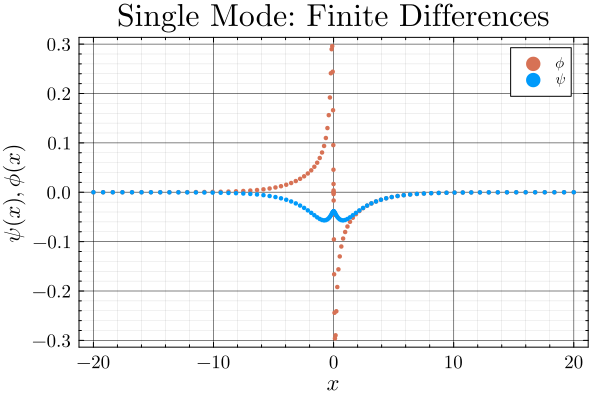

In [17]:
# plot the eigenfunctions ψ, ϕ
theme(:dao::Symbol)

myplot = scatter(x, real.(ϕ), 
    markersize=:2.5,
    label=L"$\phi$")
myplot = scatter!(x, real.(ψ),
    #xlims=(-1//2, 1//2),
    #ylims=(-.15, .15),
    markersize=:2.5,
    legend=:topright,
    label=L"$\psi$",
    title="Single Mode: Finite Differences",
    xlabel=L"$x$",
    ylabel=L"$\psi(x), \phi(x)$",
    titlefontsize=20,  # title
    tickfontsize=12,  # ticks
    legendfontsize=10, # legend
    yguidefontsize=15, # guides
    xguidefontsize=15
)

# savefig(myplot, "singlemode_tearing_soln.png")
myplot

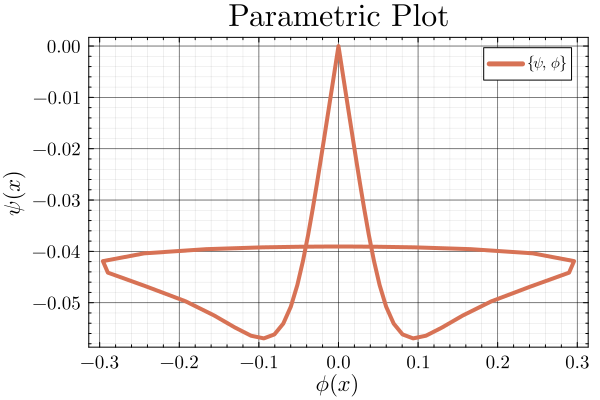

In [18]:
plot(real.(ϕ), real.(ψ),
    lw=4,
    legend=:best,
    markersize=:2.5,
    label=L"{$\psi$, $\phi$}",
    title="Parametric Plot",
    xlabel=L"$\phi(x)$",
    ylabel=L"$\psi(x)$",
    titlefontsize=20,  # title
    tickfontsize=12,  # ticks
    legendfontsize=10, # legend
    yguidefontsize=15, # guides
    xguidefontsize=15
    )

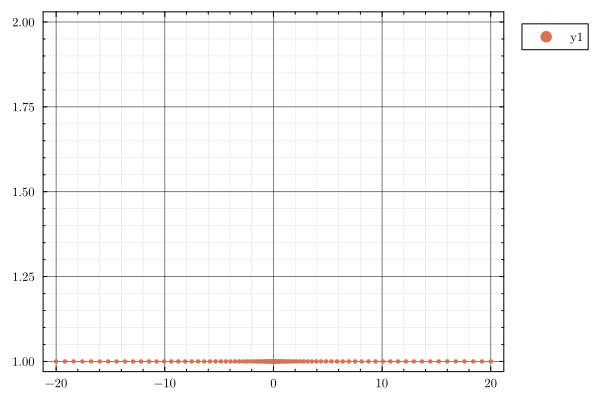

In [19]:
# plot the eigenfunctions ψ, ϕ
theme(:dao::Symbol)

myplot = scatter(x, ones(Float64, n), 
    markersize=:2.5,
)

# savefig(myplot, "singlemode_tearing_soln.png")
myplot

In [20]:
#= 
To-Do:
1. get a measurement of Δ′
2. make more efficient with multithreading
turn into Matrix shooting method, shooting on ϕ
3. use complex γ, iterate with Muller's method
=#